# <span style='background :yellow' > Assessing SMEs' GDPR-compliance Through Privacy Policies: A Machine Learning Approach </span>
<span style='background :yellow' >
The goal of this research is to explore--using natural language processing and machine learning techniques--how organisations differ in their approach towards GDPR-compliance. We intend to do this by assessing privacy policies on their *focus* (rather than completeness) of the GDPR user rights and explore whether there is a correlation with the corresponding organisation's meta-data (e.g., country, service, data-driven). This will give us insight in organisations' interpretation of the GDPR (e.g., stressing a specific part) and factors (e.g., company size) that contribute to this particular interpretation.
</span>

---
## DATASET ##
This manually labeled set comprises 250 individual policies, containing over 18,300 natural sentences. For legal reasons, we have anonymized the data set, e.g. we have scrambled all num- bers and substituted names, email addresses, companies and URLs with generic replacements (e.g. ‘company 42645’). <br>
Source: __On GDPR Compliance of Companies’ Privacy Policies__ _by Müller et al._

The five GDPR requirements chosen to evaluate privacy policy compliance:

|No.|	Category|Required content in privacy policy|
|---|---|---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

## Import labeled PPs (18.397 sentence snippets)

In [2]:
import pandas

# Let's load the training data from a csv file
dataset = pandas.read_csv('data/PP/GDPR.csv', sep='\t', encoding='utf-8')
dataset

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,this is a privacy statement disclosing our inf...,0,0,0,0,0
1,"any other information that we gather, in pursu...",0,0,0,0,0
2,in such circumstances we will continue to send...,0,0,0,0,0
3,the information is not accessible to the publi...,0,0,0,1,0
4,company_32782 ltd will use your personal data ...,0,1,0,0,0
...,...,...,...,...,...,...
18392,you agree that we have the right to share your...,0,0,0,1,0
18393,"in some cases, we may need to share your perso...",0,0,0,1,0
18394,the site includes an online tool which you can...,0,0,0,0,0
18395,that information is provided directly to the t...,0,0,0,0,0


#### Explore balance of dataset
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

Text(0.5, 0, 'GDPR Assessment Criteria')

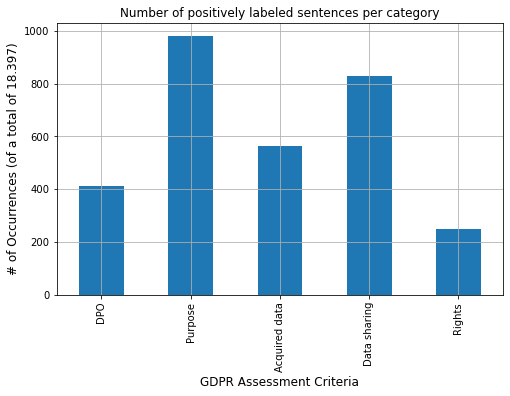

In [3]:
import matplotlib.pyplot as plt

categ = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categ:
#     print(dataset[column].value_counts())
    tmp_count = dataset[column].value_counts()
    # make a list of tuples that contain column name and number of pos labeled sentences     
    counts.append((column, tmp_count[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

#### What is the number of multi-labeled sentences?
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of GDPR criteria')

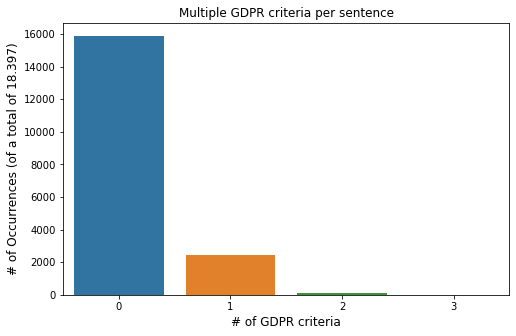

In [4]:
import seaborn as sns
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('# of GDPR criteria', fontsize=12)

- The vast majority of the sentences is not labeled at all (almost 16.000)

#### Class imbalance, possible solutions:
- oversampling minority class
    - Resample function from scikit-learn packaged: randomly duplicate examples in the minority class.
    - generating synthetic samples using SMOTE functionality in Imblearn package
- undersampling majority class

##### Oversampling should be done on the training set only:
In class imbalance settings, artificially balancing the test/validation set does not make any sense: these sets must remain realistic, i.e. you want to test your classifier performance in the real world setting, where, say, the negative class will include the 99% of the samples, in order to see how well your model will do in predicting the 1% positive class of interest without too many false positives. Artificially inflating the minority class or reducing the majority one will lead to performance metrics that are unrealistic, bearing no real relation to the real world problem you are trying to solve.

Max Kuhn, creator of the caret R package and co-author of the (highly recommended) Applied Predictive Modelling textbook, in Chapter 11: Subsampling For Class Imbalances of the caret ebook:

__You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see “in the wild”.__

Re-balancing makes sense only in the training set, so as to prevent the classifier from simply and naively classifying all instances as negative for a perceived accuracy of 99%.

Hence, you can rest assured that in the setting you describe the rebalancing takes action only for the training set/folds._

sources: 
- https://imbalanced-learn.org/stable/over_sampling.html
- https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493


#### Oversampling

In [141]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
      
def oversample_data(x, y):    
    oversample = RandomOverSampler(sampling_strategy='minority')
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

# print(Counter(y))

#### Preprocessing

In [134]:
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with numbers in them
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    
    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

In [136]:
print("Before preprocessing: ")
print(dataset['Text'].to_list()[0:3])
print()
print("Post preprocessing: ")
print(preprocessing(dataset['Text'].to_list()[:3]))

Before preprocessing: 
['this is a privacy statement disclosing our information gathering, use and dissemination practices for the company_04614 web site.', 'any other information that we gather, in pursuance of the unpaid fee, including    information that is shared by you with us.', 'in such circumstances we will continue to send you service related communications which are non-marketing where necessary.']

Post preprocessing: 
['thi is a privaci statement disclos our inform gather use and dissemin practic for the web site', 'ani other inform that we gather in pursuanc of the unpaid fee includ inform that is share by you with us', 'in such circumst we will continu to send you servic relat commun which are non-market where necessari']


## Feature engineering

#### TF-IDF
<img src="img/tfidfformula.png">


#### TF-IDF Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- fit: ...
- transform: ...
- fit transform: ...

## Train model - Classification: Logistic Regression

For classification tasks, Logistic regression models the probabability of an event occurring (e.g., "DPO", "Purpose") depending on the values of the independent variables, which are categorical (in our case even binary: "DPO" is 1 or 0).

We know that z is the weighted sum of the evidence for the class (probability of the class occurring).<br>


\begin{align}
z = c_0+c_1*𝑥_1+c_2*𝑥_2+...+c_𝑛*𝑥_𝑛
\end{align}

The larger the weight the greater impact the given feature has on the final decision:<br>
- large positive values indicate a positive impact (for the event to occur)
- large negative values indicate a negative impact (for the event not to occur)

Z value is between -∞ and +∞. 
Therefore we apply the sigmoid (or logistic function) to this value to obtain prob. values between 0 and 1.
The final probability scores let the model predict the label. If the prob of "Red" is higher than all other labels, the prediction will be "Red".

More info: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

### Optimize parameters
___max_df___ float in range [0.0, 1.0] or int, default=1.0, is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

___min_df___ float in range [0.0, 1.0] or int, default=1, is used for removing terms that appear too infrequently. For example:
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

__ngram_range___ tuple (min_n, max_n), default=(1, 1)
- The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.

___max_features___ int, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

#### Split train and test set (using stratified split) 
- Split dataset into training, 10% (= 16557), and test set (1840)

Because we have multiple labels (5), we need to conduct the train_test_split an equal amount of time to maintain the stratify functionality for each and every label.

Info about stratified split in classification problems: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=Stratified%20Train%2DTest%20Splits,-One%20final%20consideration&text=As%20such%2C%20it%20is%20desirable,a%20stratified%20train%2Dtest%20split.

In [144]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_dpo, test_dpo = train_test_split(dataset['Text'], dataset['DPO'], test_size=.1, 
                                                    random_state=42, stratify=dataset['DPO'])

x_train1, x_test1, train_purpose, test_purpose = train_test_split(dataset['Text'], dataset['Purpose'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Purpose'])

x_train2, x_test2, train_acquired_data, test_acquired_data = train_test_split(dataset['Text'], dataset['Acquired data'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Acquired data'])

x_train3, x_test3, train_data_sharing, test_data_sharing = train_test_split(dataset['Text'], dataset['Data sharing'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Data sharing'])

x_train4, x_test4, train_rights, test_rights = train_test_split(dataset['Text'], dataset['Rights'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Rights'])


train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
              test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]

train_test_text = [train_text, test_text, x_train1, x_test1, x_train2, 
              x_test2, x_train3, x_test3, x_train4, x_test4]

train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]
test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]

train_data_text = [element for i, element in enumerate(train_test_text) if i in [0, 2, 4, 6, 8]]
test_data_text = [element for i, element in enumerate(train_test_text) if i in [1, 3, 5, 7, 9]]


# if x_train5 == x_train2: 
#     print("same")

# train, test = train_test_split(dataset, test_size=0.1, random_state=42)

# train_text = preprocessing(train['Text'].to_list())
# test_text = preprocessing(test['Text'].to_list())

# train_dpo = train['DPO'].to_list()
# test_dpo = test['DPO'].to_list()

# train_purpose = train['Purpose'].to_list()
# test_purpose = test['Purpose'].to_list()

# train_acquired_data = train['Acquired data'].to_list()
# test_acquired_data = test['Acquired data'].to_list()

# train_data_sharing = train['Data sharing'].to_list()
# test_data_sharing = test['Data sharing'].to_list()

# train_rights = train['Rights'].to_list()
# test_rights = test['Rights'].to_list()

# train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
#               test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]


# test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]
# train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]

# len(train_test)

#### class distribution after stratified split

In [145]:
import collections 
# print((collections.Counter(train_data[0])))
# print((collections.Counter(test_dpo)))

for idx, ct in enumerate(categ):
    print(ct)
    
    print((collections.Counter(train_data[idx])))
    print((collections.Counter(test_data[idx])))


# frequency_calculated = ({'DPO training (1)':1, 'DPO 1':3, 'C':1, 'D':2, 'E':1, 'F':3, 'G':2})
# plt.bar(frequency_calculated.keys(), frequency_calculated.values())

DPO
Counter({0: 16184, 1: 373})
Counter({0: 1799, 1: 41})
Purpose
Counter({0: 15675, 1: 882})
Counter({0: 1742, 1: 98})
Acquired data
Counter({0: 16049, 1: 508})
Counter({0: 1783, 1: 57})
Data sharing
Counter({0: 15810, 1: 747})
Counter({0: 1757, 1: 83})
Rights
Counter({0: 16331, 1: 226})
Counter({0: 1815, 1: 25})


#### Optimize parameters
We optimize paramaters (ngrams) on the training set to avoid overfitting.

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time

In [142]:
# 'UR_explicitly_mentioned' weggelaten
# categories = ['Purpose']
# prep_dataset = preprocessing(pps = dataset['Text'].to_list())
x_train = preprocessing(train_text)
x_test = preprocessing(test_text)


for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
    }

    y_train = train_data[i]
    
    print(len(x_train))
    print(len(y_train))
    
    x_train, y_train = oversample_data(x_train, y_train)

    print(len(x_train))
    print(len(y_train))
    break

    grid_search = GridSearchCV(tfidf_pipeline, parameters)

    print("Performing grid search for label: {}".format(category))
    print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


16557
16557


ValueError: Expected 2D array, got 1D array instead:
array=['wash hand basin are posit from ground level'
 'how do i withdraw my consent' 'consent and your right to opt out' ...
 'if our store is acquir or merg with anoth compani your inform may be transfer to the new owner so that we may continu to sell product to you'
 'data we have store for other purpos eg'
 'should you wish to contact our data protect point of contact you can do so use the contact detail note at paragraph contact us below'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Predict & Evaluate
Using optimized parameters

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import pickle

In [149]:
# prep_text = preprocessing(pps = dataset['Text'].to_list())
# x_train = train_text 
# x_test = test_text

# params = [(1,1), (1,2), (1,1), (1,1), (1,1)] # stemming + stopwords + ngrams
params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # lemmatizing + ngrams


for i, category in enumerate(categ):
    print("Label in progress:" + category)
    print()
    
    # initalise the vectorizer 
#     vectorizer = TfidfVectorizer(max_df = .75, min_df = .05, ngram_range = (1,2))
    vectorizer = TfidfVectorizer(ngram_range = params[i])
    print("Ngram:", params[i])

    x_train = preprocessing(train_data_text[i])
    x_test = preprocessing(test_data_text[i])
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    y_train = train_data[i]
    y_test = test_data[i]

    x_train, y_train = oversample_data(x_train, y_train)
    
    # Make an instance of the Model
    # all parameters not specified are set to their defaults
    lr = LogisticRegression()

    # Train the model on the data, storing the information learned from the data
    # Model is learning the relationship between digits (x_train) and labels (y_train)
    
    lr.fit(x_train, y_train)
        
    # Save to file in the current working directory
    lr_file = "linreg-oversampling-" + category + ".pkl"
    with open(lr_file, 'wb') as file:
        pickle.dump((vectorizer, lr), file)
    
    
    # Let's see what are the possible labels to predict (and in which order they are stored)
    print(lr.classes_)

    # We can get additional information about all the parameters used with LogReg model
    print(lr.get_params())

    y_pred = lr.predict(x_test)
    
    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()
        
    
    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("TFIDF ROC_AUC Score", roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
    
    print("----------------------------------")
    print()

Label in progress:DPO

Ngram: (1, 1)
[0 1]
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Most important features:
0
contact 7.364027645207205
pleas 7.0788951970250755
offic 7.005051726083367
control 6.692642440422471
should 6.414522871551412
at 6.197464184592505
email 6.008544690340626
ico 5.897973207549368
telephon 5.612388689693497
post 5.608056109067657
...
INTERCEPT:-4.443313403504138
...
give -2.822697477891749
it -2.8470202055585156
phone -2.9566348003303125
account -3.035294389936908
other -3.3713209850543953
name -3.5846667430840826
not -3.7659275199892117
cooki -3.90243660960674
servic -3.9488781352868627
includ -4.224357200360155



Confusion matrix:
[[1733   66]
 [   8   33]]

Classification report:
              precision    recall  f1-score   su

### Background: performance metrics

### Accuracy ### 
For label X, precision is the number of correctly predicted labels divided by all labels<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made} = \frac{true\ positives\ +\ true\ negatives}{true\ positives\ +\ false\ positives\ +\ true\ negatives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>
true negative = correctly predicted as not label A<br>
false negative = predicted as another label, whereas it is actually label A

- ___Is not very helpful in case of class imbalance (classifying everything to the majority class will result in this case in a good accuracy)___


### Precision ### 
For label X, precision is the number of correctly predicted labels __out of all predicted labels__ (for the actual label X) (What percent of the predicted labels are correct? The focus is on predictions.).<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made\ as\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ positives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>

### Recall ### 
For label X, recall is the number of correctly predicted labels (same as above) __out of the number of actual labels A__ (Out of all actual label A's, what percent of them did the model predict correctly? The focus is on actual labels.).<br>
In other words: r = true positives / (true positives + false negatives)

\begin{align}
Recall(r) = \frac{correctly\ predicted\ as\ label\ A}{all\ actual\ items\ with\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false negative = predicted as another label, whereas it is actually label A

### F1 Score ###
Ok so precision and recall measures the performance of a model from two different perspectives.
We can combine the two measures to get a single, balanced score, which is also called __F1 score__.
Obtaining a single score is often easier to compare different models.

\begin{align}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall} \\
\end{align}

### Classification report ###
- __macro avg__: Calculate precision, recall and f1 metrics for each label, and find their average. This does not take label imbalance into account: f1 scores are averaged (with equal weights)
- __weighted avg__: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters "macro" to account for label imbalance (it can result in an F-score that is not between precision and recall).

### Confusion matrix ###

| |Actual|label|
|---|---|---|
|Predicted| TN | FP |
|label| FN | TP |

## Evaluate

#### Performance (Logistic Regression)
|Label|Approach|Precision|Recall|F1|AUC|
|---|---|---|---|---|---|
|DPO|stemming + stopwords removal + ngram(1,1)|0.81 (0.98)|0.67 (0.97)|0.72 (0.98)|0.973|
|DPO|stemming + ngram(1,1)|0.79 (0.98)|0.68 (0.98)|0.72 (0.98)|0.977|
|DPO|oversampling + stemming + ngram(1,1)|0.67 (0.98)|0.88 (0.96)|0.73 (0.97)|0.980|
|Purpose|stemming + stopwords removal + ngram(1,2)|0.88 (0.95)|0.60 (0.95)|0.65 (0.94)|0.943|
|Purpose|stemming + ngram(1,2)|0.83 (0.94)|0.61 (0.95)|0.66 (0.94)|0.936|
|Purpose|oversampling + stemming + ngram(1,2)|0.65 (0.95)|0.86 (0.90)|0.70 (0.92)|0.934|
|Acquired data|stemming + stopwords removal + ngram(1,1)|0.96 (0.98)|0.63 (0.98)|0.70 (0.97)|0.931|
|Acquired data|stemming + ngram(1,1)|0.93 (0.97)|0.63 (0.98)|0.70 (0.97)|0.942|
|Acquired data|oversampling + stemming + ngram(1,1)|0.64 (0.97)|0.79 (0.94)|0.69 (0.95)|0.930|
|Data sharing|stemming + stopwords removal + ngram(1,1)|0.87 (0.96)|0.67 (0.97)|0.73 (0.96)|0.970|
|Data sharing|stemming + ngram(1,1)|0.87 (0.96)|0.70 (0.97)|0.75 (0.96)|0.973|
|Data sharing|oversampling + stemming + ngram(1,1)|0.75 (0.97)|0.93 (0.96)|0.81 (0.96)|0.975|
|Rights|stemming + stopwords removal + ngram(1,1)|0.95 (0.99)|0.68 (0.99)|0.75 (0.99)|0.992|
|Rights|stemming + ngram(1,1)|0.95 (0.99)|0.70 (0.99)|0.78 (0.99)|0.993|
|Rights|oversampling + stemming + ngram(1,1)|0.77 (0.99)|0.95 (0.99)|0.84 (0.99)|0.996|

#### Most important features 
|DPO|Purpose|Acquired data|Data sharing|Rights|
|---|---|---|---|---|
|offic| purpos | name | shar | delet |
|email| use person | address | disclos | correct |
|pleas| follow purpos | photograph | sell | erasur |
|contac| order | detail | pass | eras |
|question| servic | record | never | remov |
|write| may use | correct | transfer | right |
|protect| data follow | health | third | rectifi |
|us| interest | number | parti | forgotten |
|control| use inform | sensit | outsid | rectifi |
|mail| use | includ | compani | request |

## Predict collected dataset of scraped SME policies

In [154]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
  
scores_sme = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\SME'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(len(csv_files))  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j)
    
    df_sme = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_sme)
    sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
          vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = sme_test_data[i]
        y_pred = lr.predict(x_test)

        if 1 in y_pred:
#                 print("i", i)
#                 print("j", j)
            scores_sme[i][j] = 1

#         print("")
#         print("")
#         print("")

1000
This is file:  0















This is file:  1















This is file:  2















This is file:  3















This is file:  4















This is file:  5















This is file:  6















This is file:  7















This is file:  8















This is file:  9















This is file:  10















This is file:  11















This is file:  12















This is file:  13















This is file:  14















This is file:  15















This is file:  16















This is file:  17















This is file:  18















This is file:  19















This is file:  20















This is file:  21















This is file:  22















This is file:  23















This is file:  24















This is file:  25















This is file:  26















This is file:  27















This is file:  28















This is file:  29















This is file:  










This is file:  245















This is file:  246















This is file:  247















This is file:  248















This is file:  249















This is file:  250















This is file:  251















This is file:  252















This is file:  253















This is file:  254















This is file:  255















This is file:  256















This is file:  257















This is file:  258















This is file:  259















This is file:  260















This is file:  261















This is file:  262















This is file:  263















This is file:  264















This is file:  265















This is file:  266















This is file:  267















This is file:  268















This is file:  269















This is file:  270















This is file:  271















This is file:  272















This is file:  273















This 







This is file:  486















This is file:  487















This is file:  488















This is file:  489















This is file:  490















This is file:  491















This is file:  492















This is file:  493















This is file:  494















This is file:  495















This is file:  496















This is file:  497















This is file:  498















This is file:  499















This is file:  500















This is file:  501















This is file:  502















This is file:  503















This is file:  504















This is file:  505















This is file:  506















This is file:  507















This is file:  508















This is file:  509















This is file:  510















This is file:  511















This is file:  512















This is file:  513















This is file:  514















This is 
















This is file:  728















This is file:  729















This is file:  730















This is file:  731















This is file:  732















This is file:  733















This is file:  734















This is file:  735















This is file:  736















This is file:  737















This is file:  738















This is file:  739















This is file:  740















This is file:  741















This is file:  742















This is file:  743















This is file:  744















This is file:  745















This is file:  746















This is file:  747















This is file:  748















This is file:  749















This is file:  750















This is file:  751















This is file:  752















This is file:  753















This is file:  754















This is file:  755















This is file:  756




























This is file:  969















This is file:  970















This is file:  971















This is file:  972















This is file:  973















This is file:  974















This is file:  975















This is file:  976















This is file:  977















This is file:  978















This is file:  979















This is file:  980















This is file:  981















This is file:  982















This is file:  983















This is file:  984















This is file:  985















This is file:  986















This is file:  987















This is file:  988















This is file:  989















This is file:  990















This is file:  991















This is file:  992















This is file:  993















This is file:  994















This is file:  995















This is file:  996















This is file:  997















Th

## Predict collected dataset of LE policies

In [ ]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
  
scores_le = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\LE'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(len(csv_files))  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j)
    
    df_sme = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_sme)
    sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
          vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = sme_test_data[i]
        y_pred = lr.predict(x_test)

        if 1 in y_pred:
#                 print("i", i)
#                 print("j", j)
            scores_sme[i][j] = 1

#         print("")
#         print("")
#         print("")

## Results 

# Optional: Classify test sets (SME & LE)
- Manually label subset of scraped dataset
- Assess performance of classifier for each of the datasets (SME, LE)

In [131]:
def get_data(df):
    test_text = df['Text'].to_list()
    test_dpo = df['DPO'].to_list()
    test_purpose = df['Purpose'].to_list()
    test_acquired_data = df['Acquired data'].to_list()
    test_data_sharing = df['Data sharing'].to_list()
    test_rights = df['Rights'].to_list()

    test_nocat_idx = df.index[((df['DPO'] == 0) & 
                             (df['Purpose'] == 0) & 
                             (df['Acquired data'] == 0) & 
                             (df['Data sharing'] == 0) & 
                             (df['Rights'] == 0))].tolist()

    test_nocat = []
    for i in range(len(df)):
        if i in test_nocat_idx:
            test_nocat.append(1)
        else:
            test_nocat.append(0)
            
    return test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat

## SME (test)

In [107]:
dataset_sme_test = pandas.read_csv('data/PP/SME-GDPR-test.csv', sep='\t', engine='python', 
                                   encoding='utf-8')
dataset_sme_test

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,date: april 2019,0,0,0,0,0
1,your privacy is of great importance to blanco ...,0,0,0,0,0
2,(hereinafter referred to as â€‹â€˜blancoâ€™).,0,0,0,0,0
3,if you use the website wwwâ€‹.useâ€‹blanâ€‹coâ...,0,0,0,0,0
4,we would like to inform you about the way we c...,0,0,0,0,0
...,...,...,...,...,...,...
512,we may also process your personal data when re...,0,0,0,0,0
513,do we share personal data?,0,0,0,0,0
514,"we do not sell, lease, rent or otherwise discl...",0,0,0,1,0
515,your consent and social sharing services : we ...,0,0,0,1,0


In [152]:
import pandas as pd
import os
import glob
  
test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(dataset_sme_test)
sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]


params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams

# x_test = test_text

index = 0

for i, category in enumerate(categ):

    filen = "linreg-oversampling-" + category + ".pkl"      
    with open(filen, 'rb') as file:
      vectorizer, lr = pickle.load(file)
    
    print("* Label = ", category)

    x_test = preprocessing(test_text)
    x_test = vectorizer.transform(x_test)

    y_test = sme_test_data[i]
    y_pred = lr.predict(x_test)

    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()


    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))

* Label =  DPO

Most important features:
0
contact 7.364027645207205
pleas 7.0788951970250755
offic 7.005051726083367
control 6.692642440422471
should 6.414522871551412
at 6.197464184592505
email 6.008544690340626
ico 5.897973207549368
telephon 5.612388689693497
post 5.608056109067657
...
INTERCEPT:-4.443313403504138
...
give -2.822697477891749
it -2.8470202055585156
phone -2.9566348003303125
account -3.035294389936908
other -3.3713209850543953
name -3.5846667430840826
not -3.7659275199892117
cooki -3.90243660960674
servic -3.9488781352868627
includ -4.224357200360155



Confusion matrix:
[[505  12]
 [  0   0]]

Classification report:


C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       517
           1       0.00      0.00      0.00         0

    accuracy                           0.98       517
   macro avg       0.50      0.49      0.49       517
weighted avg       1.00      0.98      0.99       517

* Label =  Purpose

Most important features:
0
use 7.379085209980248
administ 5.8643021759186205
purpos 5.737349213786953
enabl 5.539143800290476
to 5.340875852702784
caus 5.123441106924119
notifi 4.350029384106201
manag 4.338666022522067
qualiti 4.177122831168607
valid 4.082710922963204
...
INTERCEPT:-4.09053355537019
...
store -3.255622399592071
refer -3.264304167510739
year -3.323179275371437
pleas -3.3919053828927335
object -3.441073920893396
if -3.475295709760186
transfer -3.9463416698749008
disclos -4.0243677596616445
right -5.343316840451166
cooki -6.769226563867061



Confusion matrix:
[[446  48]
 [  7  16]]

Classification report:
              precision  

## LE (test)

In [16]:
dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')
dataset_le_test

<ipython-input-16-da02091db721>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')


,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,"in this privacy statement, de driesprong yacht...",0,0,0,0,0
1,collected personal data,0,0,0,0,0
2,we do our best to protect your data.,0,0,0,0,0
3,we need personal data to guarantee our service...,0,0,0,0,0
4,de driesprong yacht charters b.v. processes th...,0,0,0,0,0
...,...,...,...,...,...,...
511,we retain information derived from cookies and...,0,0,0,0,0
512,in some circumstances we will anonymize your p...,0,0,0,0,0
513,any personal information about you will be tre...,0,0,0,0,0
514,we are committed to delivering the rights avai...,0,0,0,0,0
